---
syncID: a9ef8a3acfb841e2b77b1f6360e22648
title: "Unsupervised Spectral Classification in Python: Endmember Extraction"
description: "Learn to classify spectral data using Endmember Extraction, Spectral Information Divergence, and Spectral Angle Mapping."
dateCreated: 2018-07-10 
authors: Bridget Hass
contributors:
estimatedTime:
packagesLibraries: numpy, gdal, matplotlib, matplotlib.pyplot
topics: hyperspectral-remote-sensing, HDF5, remote-sensing
languagesTool: python
dataProduct: NEON.DP1.30006, NEON.DP3.30006, NEON.DP1.30008
code1: Python/remote-sensing/hyperspectral-data/classification_endmember_extraction_py.ipynb
tutorialSeries: intro-hsi-py-series
urlTitle: classification-endmember-python
---

This tutorial runs through an example of spectral unmixing to carry out unsupervised classification of a SERC hyperspectral data file using the <a href="https://pysptools.sourceforge.io/index.html" target="_blank">PySpTools package</a> to carry out **endmember extraction**, plot **abundance maps** of the spectral endmembers, and use **Spectral Angle Mapping** and **Spectral Information Divergence** to classify the SERC tile. 

<div id="ds-objectives" markdown="1">

### Objectives
After completing this tutorial, you will be able to:

* Classify spectral remote sensing data. 

### Install Python Packages

* **numpy**
* **gdal** 
* **matplotlib** 
* **matplotlib.pyplot** 


### Download Data

 <a href="https://neondata.sharefile.com/d-s1dc135daffd4e65b" class="btn btn-success">
Download the spectral classification teaching data subset</a>

</div>

This tutorial runs through an example of spectral unmixing to carry out unsupervised classification of a SERC hyperspectral data file using the <a href="https://pysptools.sourceforge.io/index.html" target="_blank">PySpTools package</a> to carry out **endmember extraction**, plot **abundance maps** of the spectral endmembers, and use **Spectral Angle Mapping** and **Spectral Information Divergence** to classify the SERC tile.  

Since spectral data is so large in size, it is often useful to remove any unncessary or redundant data in order to save computational time. In this example, we will remove the water vapor bands, but you can also take a subset of bands, depending on your research application. 

## Set up

To run this notebook, the following Python packages need to be installed. 

You can install required packages from command line `pip install pysptools scikit-learn cvxopt`.

or if already in a Jupyter Notebook:  

1. PySpTools: Download <a href="https://pypi.python.org/pypi/pysptools" target="_blank">pysptools-0.14.2.tar.gz</a>.
2. Run the following code in a Notebook code cell. 

In [16]:
import sys
#!{sys.executable} -m pip install "C:\Users\bhass\Downloads\pysptools-0.14.2.tar.gz
!{sys.executable} -m pip install "C:\R\pysptools-0.14.2.tar.gz
!conda install --yes --prefix {sys.prefix} scikit-learn
!conda install --yes --prefix {sys.prefix} cvxopt

'C:\Users\Maxwell' is not recognized as an internal or external command,
operable program or batch file.

EnvironmentLocationNotFound: Not a conda environment: C:\Users\Maxwell


EnvironmentLocationNotFound: Not a conda environment: C:\Users\Maxwell



We will also use the following user-defined functions: 

* **`read_neon_reflh5`**: function to read in NEON AOP Hyperspectral Data file (in hdf5 format)
* **`clean_neon_refl_data`**: function to clean NEON hyperspectral data, including applying the data ignore value and reflectance scale factor, and removing water vapor bands
* **`plot_aop_refl`**: function to plot a band of NEON hyperspectral data for reference

Once PySpTools is installed, import the following packages. 

import h5py, os, copy
import matplotlib.pyplot as plt
import numpy as np
import pysptools.util as util
import pysptools.eea as eea #endmembers extraction algorithms
import pysptools.abundance_maps as amap
import pysptools.classification as cls
import pysptools.material_count as cnt

%matplotlib inline

#for clean output, to not print warnings, don't use when developing script
import warnings
warnings.filterwarnings('ignore')

Define the function `read_neon_reflh5` to read in the h5 file, without cleaning it (applying the no-data value and scale factor); we will do that with a separate function that also removes the water vapor bad band windows. 

In [17]:
import h5py, os, copy
import matplotlib.pyplot as plt
import numpy as np
import pysptools.util as util
import pysptools.eea as eea #endmembers extraction algorithms
import pysptools.abundance_maps as amap
import pysptools.classification as cls
import pysptools.material_count as cnt

%matplotlib inline

#for clean output, to not print warnings, don't use when developing script
import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'pysptools'

In [ ]:
def read_neon_reflh5(refl_filename):
    """read in a NEON AOP reflectance hdf5 file and returns 
    reflectance array, and metadata dictionary containing metadata 
    (similar to envi header format)
    --------
    Parameters
        refl_filename -- full or relative path and name of reflectance hdf5 file
    --------
    Returns 
    --------
    reflArray:
        array of reflectance values
    metadata:
        dictionary containing the following metadata (all strings):
            bad_band_window1: min and max wavelenths of first water vapor window (tuple)
            bad_band_window2: min and max wavelenths of second water vapor window (tuple)
            bands: # of bands (float)
            coordinate system string: coordinate system information (string)
            data ignore value: value corresponding to no data (float)
            interleave: 'BSQ' (string)
            reflectance scale factor: factor by which reflectance is scaled (float)
            wavelength: wavelength values (float)
            wavelength unit: 'm' (string)
            spatial extent: extent of tile [xMin, xMax, yMin, yMax], UTM meters
    --------
    Example Execution:
    --------
    sercRefl, sercMetadata = h5refl2array('NEON_D02_SERC_DP1_20160807_160559_reflectance.h5') """
    
    #Read in reflectance hdf5 file 
    hdf5_file = h5py.File(refl_filename,'r')

    #Get the site name
    file_attrs_string = str(list(hdf5_file.items()))
    file_attrs_string_split = file_attrs_string.split("'")
    sitename = file_attrs_string_split[1]
    
    #Extract the reflectance & wavelength datasets
    refl = hdf5_file[sitename]['Reflectance']
    reflData = refl['Reflectance_Data']
    reflArray = refl['Reflectance_Data'].value
    
    #Create dictionary containing relevant metadata information
    metadata = {}
    metadata['map info'] = refl['Metadata']['Coordinate_System']['Map_Info'].value
    metadata['wavelength'] = refl['Metadata']['Spectral_Data']['Wavelength'].value

    #Extract no data value & set no data value to NaN
    metadata['data ignore value'] = float(reflData.attrs['Data_Ignore_Value'])
    metadata['reflectance scale factor'] = float(reflData.attrs['Scale_Factor'])
    metadata['interleave'] = reflData.attrs['Interleave']
    
    #Extract spatial extent from attributes
    metadata['spatial extent'] = reflData.attrs['Spatial_Extent_meters']
    
    #Extract bad band windows
    metadata['bad_band_window1'] = (refl.attrs['Band_Window_1_Nanometers'])
    metadata['bad_band_window2'] = (refl.attrs['Band_Window_2_Nanometers'])
    
    #Extract projection information
    metadata['projection'] = refl['Metadata']['Coordinate_System']['Proj4'].value
    metadata['epsg'] = int(refl['Metadata']['Coordinate_System']['EPSG Code'].value)
    
    #Extract map information: spatial extent & resolution (pixel size)
    mapInfo = refl['Metadata']['Coordinate_System']['Map_Info'].value
    
    hdf5_file.close        
    
    return reflArray, metadata


Now that the function is defined, we can call it to read in the sample reflectance file. Note that if your data is stored in a different location, you'll have to change the relative path, or include the absolute path. 

In [ ]:
#h5refl_filename = '../data/Hyperspectral/NEON_D02_SERC_DP3_368000_4306000_reflectance.h5'
h5refl_filename = 'NEON_D02_SERC_DP3_368000_4306000_reflectance.h5'
data,metadata = read_neon_reflh5(h5refl_filename)

Let's take a quick look at the data contained in the `metadata` dictionary with a `for loop`:

In [18]:
for key in sorted(metadata.keys()):
  print(key)

bad_band_window1
bad_band_window2
data ignore value
epsg
interleave
map info
projection
reflectance scale factor
spatial extent
wavelength


    bad_band_window1
    bad_band_window2
    data ignore value
    epsg
    interleave
    map info
    projection
    reflectance scale factor
    spatial extent
    wavelength


Now we can define a function that cleans the reflectance cube. Note that this also removes the water vapor bands, stored in the metadata as `bad_band_window1` and `bad_band_window2`, as well as the last 10 bands, which tend to be noisy. It is important to remove these values before doing classification or other analysis.

In [19]:
def clean_neon_refl_data(data,metadata):
    """Clean h5 reflectance data and metadata
    1. set data ignore value (-9999) to NaN
    2. apply reflectance scale factor (10000)
    3. remove bad bands (water vapor band windows + last 10 bands): 
        Band_Window_1_Nanometers = 1340,1445
        Band_Window_2_Nanometers = 1790,1955
    """
    
    # use copy so original data and metadata doesn't change
    data_clean = data.copy().astype(float)
    metadata_clean = metadata.copy()
    
    #set data ignore value (-9999) to NaN:
    if metadata['data ignore value'] in data:
        nodata_ind = np.where(data_clean==metadata['data ignore value'])
        data_clean[nodata_ind]=np.nan 
    
    #apply reflectance scale factor (divide by 10000)
    data_clean = data_clean/metadata['reflectance scale factor']
    
    #remove bad bands 
    #1. define indices corresponding to min/max center wavelength for each bad band window:
    bb1_ind0 = np.max(np.where((np.asarray(metadata['wavelength'])<float(metadata['bad_band_window1'][0]))))
    bb1_ind1 = np.min(np.where((np.asarray(metadata['wavelength'])>float(metadata['bad_band_window1'][1]))))

    bb2_ind0 = np.max(np.where((np.asarray(metadata['wavelength'])<float(metadata['bad_band_window2'][0]))))
    bb2_ind1 = np.min(np.where((np.asarray(metadata['wavelength'])>float(metadata['bad_band_window2'][1]))))

    bb3_ind0 = len(metadata['wavelength'])-10
    
    #define valid band ranges from indices:
    vb1 = list(range(0,bb1_ind0)); 
    vb2 = list(range(bb1_ind1,bb2_ind0))
    vb3 = list(range(bb2_ind1,bb3_ind0))
    
    valid_band_range = [i for j in (range(0,bb1_ind0),
                                    range(bb1_ind1,bb2_ind0),
                                    range(bb2_ind1,bb3_ind0)) for i in j]
    
    data_clean = data_clean[:,:,vb1+vb2+vb3]
    
    metadata_clean['wavelength'] = [metadata['wavelength'][i] for i in valid_band_range]
    
    return data_clean, metadata_clean


Now, use this function to pre-process the data:

In [20]:
data_clean,metadata_clean = clean_neon_refl_data(data,metadata)

Let's see the dimensions of the data before and after cleaning:

In [21]:
print('Raw Data Dimensions:',data.shape)
print('Cleaned Data Dimensions:',data_clean.shape)

Raw Data Dimensions: (1000, 1000, 426)
Cleaned Data Dimensions: (1000, 1000, 360)


    Raw Data Dimensions: (1000, 1000, 426)
    Cleaned Data Dimensions: (1000, 1000, 360)


Note that we have retained 360 of the 426 bands. This still contains plenty of information, in your processing, you may wish to subset even further. Let's take a look at a histogram of the cleaned data:

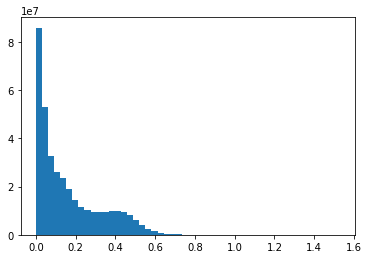

In [22]:
plt.hist(data_clean[~np.isnan(data_clean)],50);


![ ](https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/dev-aten/graphics/py-figs/classification_endmember_extraction_py/output_17_0.png)


Lastly, let's take a look at the data using the function `plot_aop_refl` function:

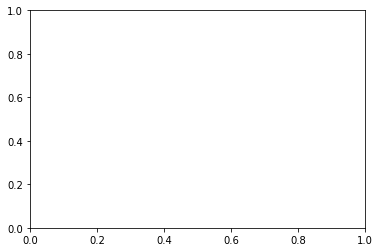

In [10]:
def plot_aop_refl(band_array,
                  refl_extent,
                  colorlimit=(0,1),
                  ax=plt.gca(),
                  title='',
                  cbar ='on',
                  cmap_title='',
                  colormap='Greys'):  
    plot = plt.imshow(band_array,extent=refl_extent,clim=colorlimit); 
    if cbar == 'on':
        cbar = plt.colorbar(plot,aspect=40); plt.set_cmap(colormap); 
        cbar.set_label(cmap_title,rotation=90,labelpad=20);
    plt.title(title); ax = plt.gca(); 
    ax.ticklabel_format(useOffset=False, style='plain'); 
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90); 

![ ](https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/dev-aten/graphics/py-figs/classification_endmember_extraction_py/output_19_0.png)

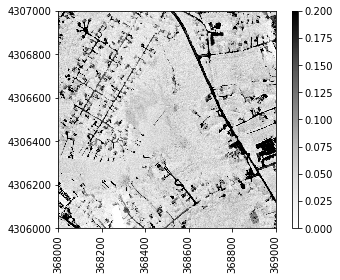

In [11]:
plot_aop_refl(data_clean[:,:,0],
              metadata_clean['spatial extent'],
              (0,0.2))

![ ](https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/dev-aten/graphics/py-figs/classification_endmember_extraction_py/output_20_0.png)


## Unsupervised Classification with Spectral Unmixing: 
### Endmember Extraction and Abundance Mapping

**Spectral Unmixing** allows pixels to be composed of fractions or abundances of each class.**Spectral Endmembers** can be thought of as the basis spectra of an image. Once these endmember spectra are determined, the image cube can be 'unmixed' into the fractional abundance of each material in each pixel (Winter, 1999).

**Spectral Angle Mapper (SAM):** is a physically-based spectral classification that uses an n-D angle to match pixels to reference spectra. The algorithm determines the spectral similarity between two spectra by calculating the angle between the spectra and treating them as vectors in a space with dimensionality equal to the number of bands. This technique, when used on calibrated reflectance data, is relatively insensitive to illumination and albedo effects. Endmember spectra used by SAM in this example are extracted from the NFINDR algorithm. SAM compares the angle between the endmember spectrum vector and each pixel vector in n-D space. Smaller angles represent closer matches to the reference spectrum. Pixels further away than the specified maximum angle threshold in radians are not classified.

Read more on Spectral Angle Mapper from 
<a href="http://www.harrisgeospatial.com/docs/SpectralAngleMapper.html" target="_blank">Harris Geospatial</a>. 

**Spectral Information Divergence (SID):** is a spectral classification method that uses a divergence measure to match pixels to reference spectra. The smaller the divergence, the more likely the pixels are similar. Pixels with a measurement greater than the specified maximum divergence threshold are not classified. Endmember spectra used by SID in this example are extracted from the NFINDR endmembor extraction algorithm.

Read more on Spectral Information Divergence from 
<a href="http://www.harrisgeospatial.com/docs/SpectralInformationDivergence.html" target="_blank">Harris Geospatial</a>. 

First we need to define the endmember extraction algorithm, and use the `extract` method to extract the endmembers from our data cube. You have to specify the # of endmembers you want to find, and can optionally specify a maximum number of iterations (by default it will use 3p, where p is the 3rd dimension of the HSI cube (m x n x p). For this example, we will specify a small # of iterations in the interest of time. 

In [12]:
#eea = data_clean
ee = eea.NFINDR()
U = ee.extract(data_clean,4,maxit=5,
               normalize=False,ATGP_init=True)

NameError: name 'eea' is not defined

In order to display these endmember spectra, we need to define the endmember axes `dictionary`. Specifically we want to show the wavelength values on the x-axis. The `metadata['wavelength']` is a `list`, but the ee_axes requires a `float` data type, so we have to cast it to the right data type. 

In [ ]:
type(metadata_clean['wavelength'])

    list

In [ ]:
ee_axes = {} # set ee_axes data type to dictionary
# cast wavelength values to float to apply to ee_axes for display purposes
ee_axes['wavelength'] = [float(i) for i in metadata_clean['wavelength']]
ee_axes['x']='Wavelength, nm' #x axis label
ee_axes['y']='Reflectance' #y axis label 

Now that the axes are defined, we can display the spectral endmembers with `ee.display`:

In [ ]:
ee.display(axes=ee_axes,suffix='SERC')

![ ](https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/dev-aten/graphics/py-figs/classification_endmember_extraction_py/output_28_0.png)


Now that we have extracted the spectral endmembers, we can take a look at the abundance maps for each member. These show the fractional components of each of the endmembers. 

In [ ]:
am = amap.FCLS() #define am object using the amap 
amaps = am.map(data_clean,U,normalize=False) #create abundance maps for the HSI cubems

Use `am.display` to plot these abundance maps:

In [ ]:
am.display(colorMap='jet',columns=4,suffix='SERC')

![ ](https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/dev-aten/graphics/py-figs/classification_endmember_extraction_py/output_32_0.png)


![ ](https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/dev-aten/graphics/py-figs/classification_endmember_extraction_py/output_32_1.png)


![ ](https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/dev-aten/graphics/py-figs/classification_endmember_extraction_py/output_32_2.png)


![ ](https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/dev-aten/graphics/py-figs/classification_endmember_extraction_py/output_32_3.png)


    <Figure size 432x288 with 0 Axes>


Print mean values of each abundance map to better estimate thresholds to use in the classification routines. 

In [ ]:
print('Abundance Map Mean Values:')
print('EM1:',np.mean(amaps[:,:,0]))
print('EM2:',np.mean(amaps[:,:,1]))
print('EM3:',np.mean(amaps[:,:,2]))
print('EM4:',np.mean(amaps[:,:,3]))

    Abundance Map Mean Values:
    EM1: 0.59177357
    EM2: 0.00089541974
    EM3: 0.3809638
    EM4: 0.026367119


You can also look at histogram of each abundance map:

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18,8))

ax1 = fig.add_subplot(2,4,1); plt.title('EM1')
amap1_hist = plt.hist(np.ndarray.flatten(amaps[:,:,0]),bins=50,range=[0,1.0]) 

ax2 = fig.add_subplot(2,4,2); plt.title('EM2')
amap1_hist = plt.hist(np.ndarray.flatten(amaps[:,:,1]),bins=50,range=[0,0.001]) 

ax3 = fig.add_subplot(2,4,3); plt.title('EM3')
amap1_hist = plt.hist(np.ndarray.flatten(amaps[:,:,2]),bins=50,range=[0,0.5]) 

ax4 = fig.add_subplot(2,4,4); plt.title('EM4')
amap1_hist = plt.hist(np.ndarray.flatten(amaps[:,:,3]),bins=50,range=[0,0.05]) 

![ ](https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/dev-aten/graphics/py-figs/classification_endmember_extraction_py/output_36_0.png)


Below we define a function to compute and display Spectral Information Diverngence (SID):

In [ ]:
def SID(data,E,thrs=None):
    sid = cls.SID()
    cmap = sid.classify(data,E,threshold=thrs)

Now we can call this function using the three endmembers (classes) that contain the most information: 

In [ ]:
U2 = U[[0,2,3],:]
SID(data_clean, U2, [0.8,0.3,0.03])

![ ](https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/dev-aten/graphics/py-figs/classification_endmember_extraction_py/output_40_0.png)


From this map we can see that SID did a pretty good job of identifying the water (dark blue), roads/buildings (orange), and vegetation (blue). We can compare it to the <a href="https://viewer.nationalmap.gov/" target="_blank">USA Topo Base map</a>.

 <figure>
	<a href="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/dev-aten/graphics/site-images/SERC_368000_4307000_UStopo.png">
	<img src="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/dev-aten/graphics/site-images/SERC_368000_4307000_UStopo.png"></a>
	<figcaption> The NEON SJER field site. Source: National Ecological Observatory Network (NEON) 
	</figcaption>
</figure>

## Challenges

1. On your own, try the Spectral Angle Mapper. If you aren't sure where to start, refer to 
<a href="https://pysptools.sourceforge.io/classification.html#spectral-angle-mapper-sam" target="_blank">PySpTools SAM documentation</a> 
and the 
<a href="https://pysptools.sourceforge.io/examples_front.html#examples-using-the-ipython-notebook" target="_blank">Pine Creek example 1</a>. 

**Hint**: use the SAM function below, and refer to the SID syntax used above. 

In [ ]:
def SAM(data,E,thrs=None):
    sam = cls.SAM()
    cmap = sam.classify(data,E,threshold=thrs)
    sam.display(colorMap='Paired')

2. Experiment with different settings with SID and SAM (e.g., adjust the # of endmembers, thresholds, etc.) 

3. Determine which algorithm (SID, SAM) you think does a better job classifying the SERC data tile. Synthesize your results in a markdown cell. 

4. Take a subset of the bands before running endmember extraction. How different is the classification if you use only half the data points? How much faster does the algorithm run? When running analysis on large data sets, it is useful to 

**Hints**: 

* To extract every 10th element from the array `A`, use `A[0::10]`
* Import the package `time` to track the amount of time it takes to run a script. 

In [ ]:
start_time = time.time()
# code
elapsed_time = time.time() - start_time

## What Next?

`PySpTools` has an alpha interface with the Python machine learning package `scikit-learn`. To apply more advanced machine learning techniques, you may wish to explore some of these algorithms.  

* <a href="https://pysptools.sourceforge.io/skl.html" target="_blank">Scikit-learn documentation on SourceForge</a>.
* <a href="http://scikit-learn.org/stable/" target="_blank">Scikit-learn website</a>.